<!-- Fraud Transactions Detection System  -->

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')


Loading data in chunks...
Using a sample of 100000 rows for initial exploration
Dataset Sample Shape: (100000, 11)

Dataset Sample Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   step            100000 non-null  int32   
 1   type            100000 non-null  category
 2   amount          100000 non-null  float32 
 3   nameOrig        100000 non-null  category
 4   oldbalanceOrg   100000 non-null  float32 
 5   newbalanceOrig  100000 non-null  float32 
 6   nameDest        100000 non-null  category
 7   oldbalanceDest  100000 non-null  float32 
 8   newbalanceDest  100000 non-null  float32 
 9   isFraud         100000 non-null  int8    
 10  isFlaggedFraud  100000 non-null  int64   
dtypes: category(3), float32(5), int32(1), int64(1), int8(1)
memory usage: 9.2 MB
None

Summary Statistics of Sample:
                s

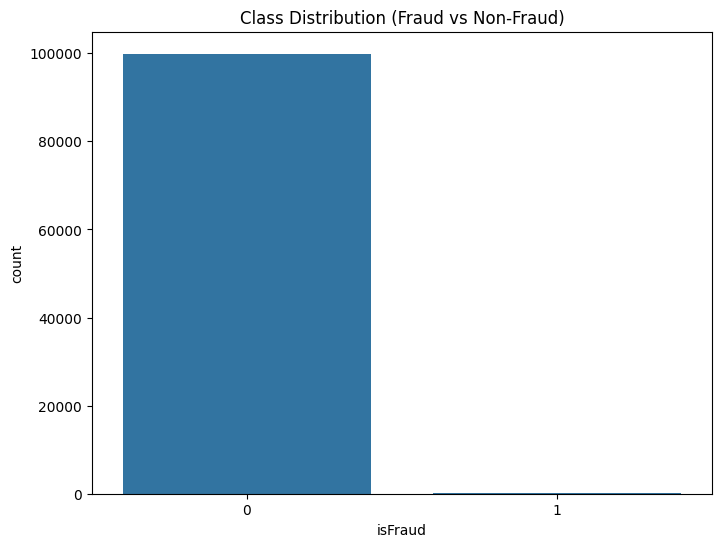

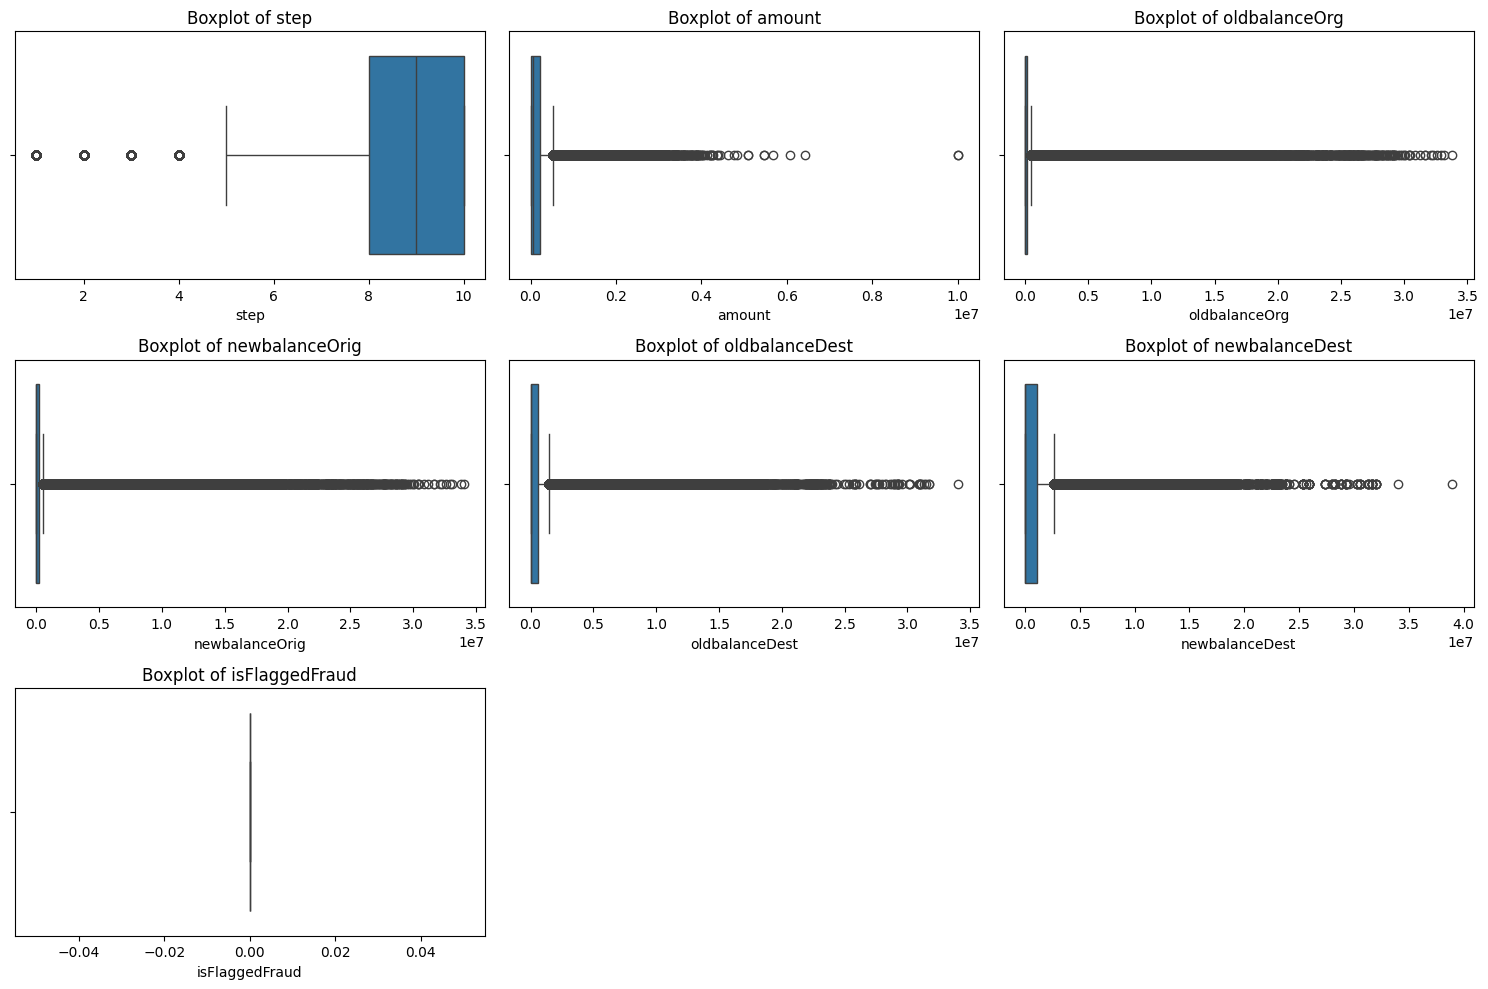


Computing correlation matrix for numerical features...

Highly Correlated Features:
newbalanceOrig & oldbalanceOrg: 0.93
newbalanceDest & oldbalanceDest: 0.87


In [3]:
# 1. Data Cleaning and Exploratory Data Analysis

# Load the dataset - use chunksize for large file
print("Loading data in chunks...")
# Determine the data types first to optimize memory usage
dtypes = {
    # Sample column datatypes - adjust based on actual data
    'step': 'int32',
    'type': 'category',
    'amount': 'float32',
    'nameOrig': 'category',
    'oldbalanceOrg': 'float32',
    'newbalanceOrig': 'float32',
    'nameDest': 'category',
    'oldbalanceDest': 'float32',
    'newbalanceDest': 'float32',
    'isFraud': 'int8'
}

# Load data in chunks and process each chunk
chunk_size = 100000
chunks = pd.read_csv('Fraud.csv', dtype=dtypes, chunksize=chunk_size)

# For initial exploration, use a small sample of the data
sample_size = 100000
df_sample = next(chunks)
for i, chunk in enumerate(chunks):
    if len(df_sample) < sample_size:
        df_sample = pd.concat([df_sample, chunk])
    if len(df_sample) >= sample_size:
        df_sample = df_sample.iloc[:sample_size]
        break
    if i > 10:  # Limit chunks processed for initial exploration
        break

print(f"Using a sample of {len(df_sample)} rows for initial exploration")

# Display basic information about the sample
print("Dataset Sample Shape:", df_sample.shape)
print("\nDataset Sample Information:")
print(df_sample.info())
print("\nSummary Statistics of Sample:")
print(df_sample.describe())

# Check for missing values in the sample
print("\nMissing Values Count in Sample:")
print(df_sample.isnull().sum())

# Identify numerical and categorical features
numerical_features = df_sample.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns
categorical_features = df_sample.select_dtypes(include=['category', 'object']).columns

# Remove target from features
target_column = 'isFraud'  # adjust as per actual column name
if target_column in numerical_features:
    numerical_features = [col for col in numerical_features if col != target_column]

# Check for class imbalance
print("\nClass Distribution in Sample:")
print(df_sample[target_column].value_counts())
print(df_sample[target_column].value_counts() / len(df_sample))

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target_column, data=df_sample)
plt.title('Class Distribution (Fraud vs Non-Fraud)')
# plt.savefig('class_distribution.png')
# plt.close()
plt.show()

# Check for outliers in sample numerical features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features[:9]):  # Limit to max 9 plots
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=feature, data=df_sample)
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
# plt.savefig('outliers_check.png')
# plt.close()
plt.show()

# Handle outliers using IQR method for key numerical features in sample
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap the outliers
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    return df

# Apply outlier handling to amount-related columns in the sample
for feature in numerical_features:
    if feature != target_column and ('amount' in feature.lower() or 'value' in feature.lower() or 'balance' in feature.lower()):
        df_sample = handle_outliers(df_sample, feature)

# Check for multicollinearity in the sample
print("\nComputing correlation matrix for numerical features...")
numerical_df = df_sample[numerical_features]
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Numerical Features')
plt.savefig('correlation_matrix.png')
plt.close()

# Print highly correlated features (above 0.7)
print("\nHighly Correlated Features:")
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

for var1, var2, corr in corr_pairs:
    print(f"{var1} & {var2}: {corr:.2f}")



In [4]:
# 2. Feature Selection and Engineering for the Full Dataset

# Based on the exploration of the sample, set up preprocessing pipelines
# Create transformers with memory-efficient operations

# Only select most important categorical features to reduce dimensionality
# This is a critical step to prevent memory errors
# For example, if 'nameOrig' and 'nameDest' are highly cardinal (many unique values)
# we might want to exclude them or process them specially
high_cardinal_features = []
for feature in categorical_features:
    unique_count = df_sample[feature].nunique()
    if unique_count > 1000:  # adjust threshold as needed
        high_cardinal_features.append(feature)
        print(f"High cardinality feature: {feature} with {unique_count} unique values")

# Exclude very high cardinality features or process them differently
categorical_features_to_use = [col for col in categorical_features if col not in high_cardinal_features]

# Add a special handling for high cardinality features if needed
# For example, creating frequency encoding instead of one-hot encoding
for feature in high_cardinal_features:
    value_counts = df_sample[feature].value_counts()
    # Keep only top N most frequent values, map others to 'Other'
    top_n = 50  # adjust as needed
    top_values = value_counts.nlargest(top_n).index
    df_sample[f"{feature}_processed"] = df_sample[feature].apply(lambda x: x if x in top_values else 'Other')
    # Add to categorical features to use
    categorical_features_to_use.append(f"{feature}_processed")

# Feature Engineering based on domain knowledge
# These operations should be efficient and meaningful for fraud detection

# Create time-based features if timestamp or step is available
if 'step' in df_sample.columns:
    # Assuming 'step' represents a time unit
    df_sample['step_mod_24'] = df_sample['step'] % 24  # time of day if steps are hours
    numerical_features = list(numerical_features) + ['step_mod_24']

# Create amount-related features if available
if 'amount' in df_sample.columns:
    # Log transform for skewed amount distribution
    df_sample['log_amount'] = np.log1p(df_sample['amount'])
    numerical_features = list(numerical_features) + ['log_amount']

# Transaction difference features
if all(col in df_sample.columns for col in ['oldbalanceOrg', 'newbalanceOrig']):
    df_sample['balance_diff_orig'] = df_sample['newbalanceOrig'] - df_sample['oldbalanceOrg']
    numerical_features = list(numerical_features) + ['balance_diff_orig']

if all(col in df_sample.columns for col in ['oldbalanceDest', 'newbalanceDest']):
    df_sample['balance_diff_dest'] = df_sample['newbalanceDest'] - df_sample['oldbalanceDest']
    numerical_features = list(numerical_features) + ['balance_diff_dest']

# Create suspicious transaction flags
# Example: Flag if transaction amount equals account balance
if all(col in df_sample.columns for col in ['amount', 'oldbalanceOrg']):
    df_sample['amount_equals_balance'] = (df_sample['amount'] == df_sample['oldbalanceOrg']).astype(int)
    numerical_features = list(numerical_features) + ['amount_equals_balance']

# 3. Setup Efficient Preprocessing Pipeline 

# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Use sparse matrices for one-hot encoding to save memory
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Combine preprocessing steps in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features_to_use)
    ],
    sparse_threshold=0.8  # Use sparse matrices when possible
)

# 4. Process Data in Chunks and Train Model

# Function to process chunks and collect samples for training
def process_chunks_and_sample(file_path, target_column, chunk_size=100000, n_samples=1000000):
    """
    Process data in chunks and collect balanced samples for training
    """
    # Using generator expression to read chunks
    chunks = pd.read_csv(file_path, dtype=dtypes, chunksize=chunk_size)
    
    # Containers to collect samples
    fraud_samples = pd.DataFrame()
    non_fraud_samples = pd.DataFrame()
    
    # Number of fraud and non-fraud samples to collect
    n_fraud = n_samples // 2
    n_non_fraud = n_samples // 2
    
    print("Collecting balanced sample from full dataset...")
    for chunk in chunks:
        # Apply feature engineering to chunk
        # Time-based features
        if 'step' in chunk.columns:
            chunk['step_mod_24'] = chunk['step'] % 24
        
        # Amount-related features
        if 'amount' in chunk.columns:
            chunk['log_amount'] = np.log1p(chunk['amount'])
        
        # Transaction difference features
        if all(col in chunk.columns for col in ['oldbalanceOrg', 'newbalanceOrig']):
            chunk['balance_diff_orig'] = chunk['newbalanceOrig'] - chunk['oldbalanceOrg']
        
        if all(col in chunk.columns for col in ['oldbalanceDest', 'newbalanceDest']):
            chunk['balance_diff_dest'] = chunk['newbalanceDest'] - chunk['oldbalanceDest']
        
        # Suspicious flags
        if all(col in chunk.columns for col in ['amount', 'oldbalanceOrg']):
            chunk['amount_equals_balance'] = (chunk['amount'] == chunk['oldbalanceOrg']).astype(int)
        
        # Process high cardinality features
        for feature in high_cardinal_features:
            if feature in chunk.columns:
                chunk[f"{feature}_processed"] = chunk[feature].apply(
                    lambda x: x if x in top_values else 'Other')
        
        # Split chunk into fraud and non-fraud
        fraud_chunk = chunk[chunk[target_column] == 1]
        non_fraud_chunk = chunk[chunk[target_column] == 0]
        
        # Add to samples if needed
        if len(fraud_samples) < n_fraud:
            fraud_samples = pd.concat([fraud_samples, fraud_chunk])
            if len(fraud_samples) > n_fraud:
                fraud_samples = fraud_samples.iloc[:n_fraud]
        
        if len(non_fraud_samples) < n_non_fraud:
            # Randomly sample to avoid bias
            sample_size = min(len(non_fraud_chunk), n_non_fraud - len(non_fraud_samples))
            non_fraud_samples = pd.concat([non_fraud_samples, non_fraud_chunk.sample(sample_size)])
        
        # Check if we have enough samples
        if len(fraud_samples) >= n_fraud and len(non_fraud_samples) >= n_non_fraud:
            break
    
    # Combine samples
    balanced_sample = pd.concat([fraud_samples, non_fraud_samples])
    
    # Shuffle the data
    balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"Collected balanced sample with {len(balanced_sample)} rows")
    print(f"Class distribution: {balanced_sample[target_column].value_counts()}")
    
    return balanced_sample

# Collect a balanced sample from the full dataset
# For a real implementation, use the actual file path
balanced_df = process_chunks_and_sample('Fraud.csv', target_column)

# Split the balanced data
X = balanced_df.drop(target_column, axis=1)
y = balanced_df[target_column]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Fit the preprocessor on training data
print("Fitting preprocessing pipeline...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed test data shape: {X_test_processed.shape}")


High cardinality feature: nameOrig with 100000 unique values
High cardinality feature: nameDest with 51551 unique values
Collected balanced sample with 508213 rows
Class distribution: isFraud
0    500000
1      8213
Name: count, dtype: int64
Fitting preprocessing pipeline...
Processed training data shape: (355749, 69)
Processed test data shape: (152464, 69)


In [5]:
# 5. Train Models with Reduced Complexity

# Start with simpler models and parameters to reduce memory usage
# We'll use RandomForest as our main model since it's effective for fraud detection
print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100,  # Reduce from default for memory efficiency
    max_depth=10,      # Limit tree depth 
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,         # Use all cores
    random_state=42,
    class_weight='balanced'  # Instead of SMOTE, use class weights
)

# Train the model
rf_model.fit(X_train_processed, y_train)

# For comparison, also train a simpler model like Gradient Boosting
# with limited parameters
print("Training Gradient Boosting model...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Train the model
gb_model.fit(X_train_processed, y_train)

# 6. Model Evaluation

# Function to evaluate model
def evaluate_model(model, X_processed, y_true, model_name):
    """
    Evaluate model performance with key metrics
    """
    y_pred = model.predict(X_processed)
    y_prob = model.predict_proba(X_processed)[:,1]
    
    # Classification metrics
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.close()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.savefig(f'{model_name}_roc_curve.png')
    plt.close()
    
    # Precision-Recall Curve (better for imbalanced datasets)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    avg_precision = average_precision_score(y_true, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR curve (AP = {avg_precision:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower left")
    plt.savefig(f'{model_name}_pr_curve.png')
    plt.close()
    
    return {
        'model': model_name,
        'auc': roc_auc,
        'avg_precision': avg_precision
    }

# Evaluate Random Forest model
rf_metrics = evaluate_model(rf_model, X_test_processed, y_test, "RandomForest")

# Evaluate Gradient Boosting model
gb_metrics = evaluate_model(gb_model, X_test_processed, y_test, "GradientBoosting")

# Compare models
models_comparison = pd.DataFrame([rf_metrics, gb_metrics])
print("\nModels Comparison:")
print(models_comparison)

# Select the best model based on AUC
best_model_index = models_comparison['auc'].idxmax()
best_model_name = models_comparison.loc[best_model_index, 'model']
print(f"\nBest Model: {best_model_name}")

if best_model_name == "RandomForest":
    best_model = rf_model
else:
    best_model = gb_model

# 7. Feature Importance Analysis

# Get feature importance from the best model
feature_importance = best_model.feature_importances_

# Get feature names (this requires some work with the preprocessor)
# For one-hot encoded features, we need to extract the names from the transformer
def get_feature_names(column_transformer):
    """Get feature names from column transformer"""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name == 'cat':
            for i, feature in enumerate(features):
                cats = pipe.named_steps['onehot'].categories_[i]
                for cat in cats:
                    output_features.append(f"{feature}_{cat}")
        else:
            output_features.extend(features)
    
    return output_features

# Try to get feature names, but have a fallback if it fails
try:
    feature_names = get_feature_names(preprocessor)
    # If length doesn't match, use numbered features
    if len(feature_names) != len(feature_importance):
        feature_names = [f"feature_{i}" for i in range(len(feature_importance))]
except:
    feature_names = [f"feature_{i}" for i in range(len(feature_importance))]

# Create and sort feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
top_n = min(20, len(feature_importance_df))  # In case we have fewer than 20 features
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n))
plt.title(f'Top {top_n} Most Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))

# 8. Recommendations for Fraud Prevention

print("\nRecommendations for Fraud Prevention:")
print("1. Implement real-time transaction monitoring based on the model")
print("2. Develop a multi-factor authentication system for high-risk transactions")
print("3. Set up customized alerts based on unusual patterns in key features")
print("4. Create dynamic transaction limits based on customer behavior")
print("5. Implement behavioral analytics to detect unusual activities")

# 9. Measuring Effectiveness of Prevention Strategies

print("\nMeasuring Effectiveness of Prevention Strategies:")
print("1. Monitor false positive and false negative rates over time")
print("2. Track reduction in fraud losses compared to baseline period")
print("3. Measure customer friction and satisfaction scores")
print("4. Conduct A/B testing on fraud prevention measures")
print("5. Calculate ROI of fraud prevention measures")

# 10. Save the model for deployment
import pickle
with open('fraud_detection_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("\nModel saved successfully as 'fraud_detection_model.pkl'")

# 11. Create a real-time prediction function
def predict_fraud_probability(transaction_data, model, preprocessor):
    """
    Function to predict fraud probability for new transactions
    
    Parameters:
    transaction_data: DataFrame containing transaction information
    model: Trained fraud detection model
    preprocessor: Fitted preprocessing pipeline
    
    Returns:
    DataFrame with original data and fraud probability
    """
    # Apply the same feature engineering as during training
    processed_data = transaction_data.copy()
    
    # Add engineered features
    if 'step' in processed_data.columns:
        processed_data['step_mod_24'] = processed_data['step'] % 24
    
    if 'amount' in processed_data.columns:
        processed_data['log_amount'] = np.log1p(processed_data['amount'])
    
    if all(col in processed_data.columns for col in ['oldbalanceOrg', 'newbalanceOrig']):
        processed_data['balance_diff_orig'] = processed_data['newbalanceOrig'] - processed_data['oldbalanceOrg']
    
    if all(col in processed_data.columns for col in ['oldbalanceDest', 'newbalanceDest']):
        processed_data['balance_diff_dest'] = processed_data['newbalanceDest'] - processed_data['oldbalanceDest']
    
    if all(col in processed_data.columns for col in ['amount', 'oldbalanceOrg']):
        processed_data['amount_equals_balance'] = (processed_data['amount'] == processed_data['oldbalanceOrg']).astype(int)
    
    # Process high cardinality features
    for feature in high_cardinal_features:
        if feature in processed_data.columns:
            processed_data[f"{feature}_processed"] = processed_data[feature].apply(
                lambda x: x if x in top_values else 'Other')
    
    # Preprocess the data
    processed_features = preprocessor.transform(processed_data)
    
    # Get fraud probability
    fraud_prob = model.predict_proba(processed_features)[:, 1]
    
    # Add prediction to original data
    transaction_data['fraud_probability'] = fraud_prob
    transaction_data['is_suspicious'] = fraud_prob > 0.7  # Threshold can be adjusted
    
    return transaction_data

print("\nFraud Detection Solution Complete!")

Training Random Forest model...
Training Gradient Boosting model...

Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    150000
           1       1.00      1.00      1.00      2464

    accuracy                           1.00    152464
   macro avg       1.00      1.00      1.00    152464
weighted avg       1.00      1.00      1.00    152464


Classification Report for GradientBoosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    150000
           1       1.00      1.00      1.00      2464

    accuracy                           1.00    152464
   macro avg       1.00      1.00      1.00    152464
weighted avg       1.00      1.00      1.00    152464


Models Comparison:
              model       auc  avg_precision
0      RandomForest  0.999616       0.998746
1  GradientBoosting  0.999390       0.996925

Best Model: RandomForest

Top 10 Mos